If diff is within thershold, remove it. Thus, larger threshold means MORE are removed. Smaller threshold means more are kept.

In [1]:
!pip install jaxlib==0.4.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.20+cuda11.cudnn86
    Uninstalling jaxlib-0.4.20+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.20+cuda11.cudnn86


#ACDC Main Demo

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [2]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@d89f7fa9cbd095202f3940c889cb7c6bf5a9b516",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

Running as a Colab notebook
  Cloning https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git (to revision d89f7fa9cbd095202f3940c889cb7c6bf5a9b516) to /tmp/pip-req-build-tn4plquy
  Running command git clone --filter=blob:none --quiet https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git /tmp/pip-req-build-tn4plquy
  Running command git rev-parse -q --verify 'sha^d89f7fa9cbd095202f3940c889cb7c6bf5a9b516'
  Running command git fetch -q https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git d89f7fa9cbd095202f3940c889cb7c6bf5a9b516
  Running command git checkout -q d89f7fa9cbd095202f3940c889cb7c6bf5a9b516
  Resolved https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git to commit d89f7fa9cbd095202f3940c889cb7c6bf5a9b516
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/deepmind/tracr.git (to revision e75ecda) to /tmp/pip-install-cpmwq2fa/tracr_5

<h2>Imports etc</h2>

In [3]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

#Parse args
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [4]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')


# CHANGE TASK HERE

if ipython is not None:
    # We are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        # [line.strip() for line in r"""--task=induction\
        # [line.strip() for line in r"""--task=greaterthan\
        [line.strip() for line in r"""--task=ioi\
--zero-ablation\
--threshold=0.71\
--indices-mode=reverse\
--first-cache-cpu=False\
--second-cache-cpu=False\
--max-num-epochs=100000""".split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# Process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else:
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

In [5]:
TASK

'ioi'

In [6]:
# THRESHOLD

In [7]:
THRESHOLD = 0.1

In [8]:
ZERO_ABLATION = True

#Setup Task

In [9]:

second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10
    seq_len = 300
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


/usr/local/lib/python3.10/dist-packages/acdc/ioi/ioi_dataset.py:514: UserWarning: S2 index has been computed as the same for S and S2
  warnings.warn("S2 index has been computed as the same for S and S2")


# load data

In [10]:
things.validation_data.size()

torch.Size([100, 15])

In [11]:
things.test_data.size()

torch.Size([100, 15])

https://github.com/ArthurConmy/Automatic-Circuit-Discovery/blob/main/acdc/ioi/utils.py#L38

In [12]:
device=DEVICE

def get_gpt2_small(device="cuda") -> HookedTransformer:
    tl_model = HookedTransformer.from_pretrained("gpt2")
    tl_model = tl_model.to(device)
    tl_model.set_use_attn_result(True)
    tl_model.set_use_split_qkv_input(True)
    if "use_hook_mlp_in" in tl_model.cfg.to_dict():
        tl_model.set_use_hook_mlp_in(True)
    return tl_model

tl_model = get_gpt2_small(device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


In [13]:
# from acdc.ioi.ioi_dataset import IOIDataset

# ioi_dataset = IOIDataset(
#         prompt_type="ABBA",
#         N=num_examples*2,
#         nb_templates=1,
#         seed = 0,
#     )

# abc_dataset = (
#         ioi_dataset.gen_flipped_prompts(("IO", "RAND"), seed=1)
#         .gen_flipped_prompts(("S", "RAND"), seed=2)
#         .gen_flipped_prompts(("S1", "RAND"), seed=3)
#     )

# seq_len = ioi_dataset.toks.shape[1]
# assert seq_len == 16, f"Well, I thought ABBA #1 was 16 not {seq_len} tokens long..."

# default_data = ioi_dataset.toks.long()[:num_examples*2, : seq_len - 1].to(device)
# patch_data = abc_dataset.toks.long()[:num_examples*2, : seq_len - 1].to(device)
# labels = ioi_dataset.toks.long()[:num_examples*2, seq_len-1]
# wrong_labels = torch.as_tensor(ioi_dataset.s_tokenIDs[:num_examples*2], dtype=torch.long, device=device)

# assert torch.equal(labels, torch.as_tensor(ioi_dataset.io_tokenIDs, dtype=torch.long))
# labels = labels.to(device)

# validation_data = default_data[:num_examples, :]
# validation_patch_data = patch_data[:num_examples, :]
# validation_labels = labels[:num_examples]
# validation_wrong_labels = wrong_labels[:num_examples]

# test_data = default_data[num_examples:, :]
# test_patch_data = patch_data[num_examples:, :]
# test_labels = labels[num_examples:]
# test_wrong_labels = wrong_labels[num_examples:]


# with torch.no_grad():
#     base_model_logits = tl_model(default_data)[:, -1, :]
#     base_model_logprobs = F.log_softmax(base_model_logits, dim=-1)

# base_validation_logprobs = base_model_logprobs[:num_examples, :]
# base_test_logprobs = base_model_logprobs[num_examples:, :]

In [14]:
# ioi_dataset.toks.long().size()

# try on seq cont data

In [15]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        # prompt_dict = {
        #     'S1': str(i),
        #     'S2': str(i+1),
        #     'S3': str(i+2),
        #     'S4': str(i+3),
        #     'corr': str(i+4),
        #     'incorr': str(i+3),
        #     'text': f"{i} {i+1} {i+2} {i+3}"
        # }
        # prompts_list.append(prompt_dict)
        prompts_list.append(f"{i} {i+1} {i+2} {i+3}")
    return prompts_list

prompts_list = generate_prompts_list(1, 101)

In [16]:
import random

def generate_prompts_list_corr(x ,y):
    prompts_list = []
    for i in range(x, y):
        r1 = random.randint(1, 100)
        r2 = random.randint(1, 100)
        while True:
            r3 = random.randint(1, 100)
            r4 = random.randint(1, 100)
            if r4 - 1 != r3:
                break
        prompts_list.append(f"{i} {i+1} {i+2} {i+3}")
    return prompts_list

prompts_list_2 = generate_prompts_list_corr(1, 101)

In [17]:
toks = torch.Tensor(tl_model.tokenizer(prompts_list, padding=True).input_ids).type(torch.int)
toks_corr = torch.Tensor(tl_model.tokenizer(prompts_list_2, padding=True).input_ids).type(torch.int)

In [18]:
toks.size()

torch.Size([100, 4])

In [19]:
toks.size()[0] // 2

50

In [20]:
num_examples = toks.size()[0] # // 2

seq_len = toks.shape[1]

default_data = toks.long()[:num_examples*2, : seq_len - 1].to(device)
patch_data = toks_corr.long()[:num_examples*2, : seq_len - 1].to(device)

validation_data = default_data[:num_examples, :]
validation_patch_data = patch_data[:num_examples, :]

# test_data = default_data[num_examples:, :]
# test_patch_data = patch_data[num_examples:, :]

with torch.no_grad():
    base_model_logits = tl_model(default_data)[:, -1, :]
    base_model_logprobs = F.log_softmax(base_model_logits, dim=-1)

base_validation_logprobs = base_model_logprobs[:num_examples, :]
# base_test_logprobs = base_model_logprobs[num_examples:, :]

In [21]:
base_validation_logprobs.size()

torch.Size([100, 50257])

In [22]:
# base_test_logprobs.size()

In [23]:
base_model_logprobs.size()

torch.Size([100, 50257])

In [24]:
from functools import partial
from acdc.acdc_utils import MatchNLLMetric, frac_correct_metric, logit_diff_metric, kl_divergence, negative_log_probs

validation_metric = partial(
    kl_divergence,
    base_model_logprobs=base_validation_logprobs,
    last_seq_element_only=True,
    base_model_probs_last_seq_element_only=False,
    return_one_element=True,
)

In [25]:
# F.kl_div(base_validation_logprobs, base_test_logprobs, log_target=True, reduction="none").sum(dim=-1)

#Setup ACDC Experiment

<p> Let's define the four most important objects for ACDC experiments:

In [26]:
# validation_metric = things.validation_metric # metric we use (e.g KL divergence)
# toks_int_values = things.validation_data # clean data x_i
# toks_int_values_other = things.validation_patch_data # corrupted data x_i'
toks_int_values = validation_data # clean data x_i
toks_int_values_other = validation_patch_data # corrupted data x_i'
# tl_model = things.tl_model # transformerlens model

# if RESET_NETWORK:
#     reset_network(TASK, DEVICE, tl_model)

In [27]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

/usr/local/lib/python3.10/dist-packages/acdc/TLACDCExperiment.py:132: UserWarning: We shall overwrite the ref_ds with zeros.
  warnings.warn("We shall overwrite the ref_ds with zeros.")


dict_keys(['blocks.11.hook_resid_post', 'blocks.11.hook_mlp_out', 'blocks.11.hook_mlp_in', 'blocks.11.attn.hook_result', 'blocks.11.attn.hook_q', 'blocks.11.hook_q_input', 'blocks.11.attn.hook_k', 'blocks.11.hook_k_input', 'blocks.11.attn.hook_v', 'blocks.11.hook_v_input', 'blocks.10.hook_mlp_out', 'blocks.10.hook_mlp_in', 'blocks.10.attn.hook_result', 'blocks.10.attn.hook_q', 'blocks.10.hook_q_input', 'blocks.10.attn.hook_k', 'blocks.10.hook_k_input', 'blocks.10.attn.hook_v', 'blocks.10.hook_v_input', 'blocks.9.hook_mlp_out', 'blocks.9.hook_mlp_in', 'blocks.9.attn.hook_result', 'blocks.9.attn.hook_q', 'blocks.9.hook_q_input', 'blocks.9.attn.hook_k', 'blocks.9.hook_k_input', 'blocks.9.attn.hook_v', 'blocks.9.hook_v_input', 'blocks.8.hook_mlp_out', 'blocks.8.hook_mlp_in', 'blocks.8.attn.hook_result', 'blocks.8.attn.hook_q', 'blocks.8.hook_q_input', 'blocks.8.attn.hook_k', 'blocks.8.hook_k_input', 'blocks.8.attn.hook_v', 'blocks.8.hook_v_input', 'blocks.7.hook_mlp_out', 'blocks.7.hook_ml

#Run steps of ACDC:

iterate over a NODE in the model's computational graph
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 32923
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.hook_mlp_out [:] is 0.2213408201932907 (and current metric 0.0)
Result is 0.2213408201932907...so keeping connection
No edge 32923

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 0] is 0.4143104553222656 (and current metric 8.772330417627927e-09)
Result is 0.4143104465499352...so keeping connection

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 1] is 0.0010747432243078947 (and current metric 8.772330417627927e-09)
Result is 0.001074734451977477...so rem

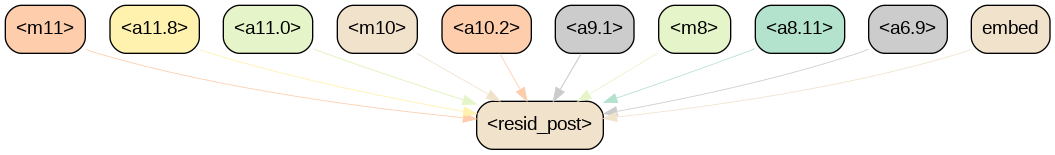

0 --------------------------------------------------
No edge 32776
32776
No edge 32776
New metric: 0.7370190024375916
No edge 32776
We moved to  blocks.11.hook_mlp_in[:]
No edge 32776


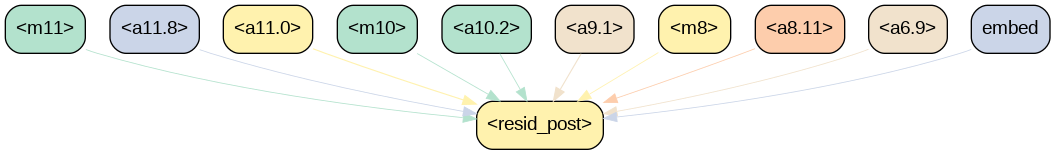

1 --------------------------------------------------
No edge 32776
32776
No edge 32776
New metric: 0.7370190024375916

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.hook_mlp_in, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 0] is 2.806974411010742 (and current metric 0.7370190024375916)
Result is 2.0699554085731506...so keeping connection

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.11.hook_mlp_in, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 1] is 0.8113753199577332 (and current metric 0.7370190024375916)
Result is 0.0743563175201416...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.11.hook_mlp_in, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 2] is 0.83268445

In [ ]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=False,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
<p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [ ]:
exp.save_subgraph(
    return_it=True,
)

In [ ]:
import zipfile
import os
from google.colab import files as colab_files

directory_path = "/content/ims"

zip_file_path = "/content/images.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, _, files_list in os.walk(directory_path):
        for file in files_list:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, directory_path))
colab_files.download(zip_file_path)